In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1 Exportando os dados:

Montei as pastas de treino e validação no drive tentando equilibrar a distribuição das imagens, o dataset original tem muito mais imagens de não carecas, então tentei equilibrar. No treino tem mais ou menos 5000 imagens de não calvos e 3000 mil de calvos, na validação 1000 não calvos e 500 calvos.
As imagens foram retiradas do dataset disponível em https://www.kaggle.com/datasets/ashishjangra27/bald-classification-200k-images-celeba

In [ ]:
train_dir = '/content/drive/MyDrive/CVCalvos/Train'
val_dir= '/content/drive/MyDrive/CVCalvos/Validation'

In [ ]:
!ls {train_dir}

Bald  Notbald


In [ ]:
!ls {val_dir}

Bald  Notbald


In [ ]:
batch_size = 64
size = (224, 224)
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=size, batch_size=batch_size, class_mode='categorical')

Found 8658 images belonging to 2 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(val_dir, target_size=size, batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 1470 images belonging to 2 classes.


In [ ]:
labels_reais = val_generator.classes

#2 modelo

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 28, 28, 256)     

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/CVCalvos/best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
lr=0.01
optimizer=Adam(learning_rate= lr)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,steps_per_epoch=train_generator.samples // batch_size, epochs=7, validation_data=val_generator, validation_steps=val_generator.samples // batch_size, callbacks=[early_stopping, model_checkpoint])
#acabei tendo que treinar o modelo uma segunda vez, pq esqueci de colocar o checkpoint na lista de callbacks

Epoch 1/7
135/135 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9037
Epoch 1: val_loss improved from inf to 0.19650, saving model to /content/drive/MyDrive/CVCalvos/best_model.h5
135/135 [==============================] - 46s 332ms/step - loss: 0.2395 - accuracy: 0.9037 - val_loss: 0.1965 - val_accuracy: 0.9134
Epoch 2/7
135/135 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9061
Epoch 2: val_loss improved from 0.19650 to 0.19488, saving model to /content/drive/MyDrive/CVCalvos/best_model.h5
135/135 [==============================] - 48s 357ms/step - loss: 0.2342 - accuracy: 0.9061 - val_loss: 0.1949 - val_accuracy: 0.9219
Epoch 3/7
135/135 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9123
Epoch 3: val_loss did not improve from 0.19488
135/135 [==============================] - 40s 293ms/step - loss: 0.2253 - accuracy: 0.9123 - val_loss: 0.2067 - val_accuracy: 0.9190
Epoch 4/7
135/135 [=======================

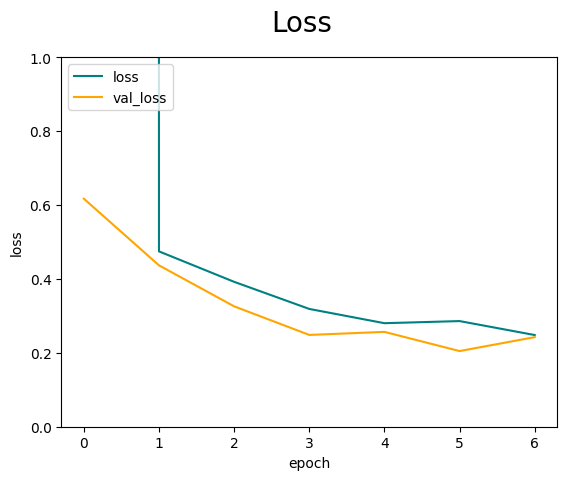

In [ ]:
#Os gráficos representam o primeiro treinamento
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.ylim(0, 1.0)
plt.xlabel('epoch')
plt.ylabel('loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

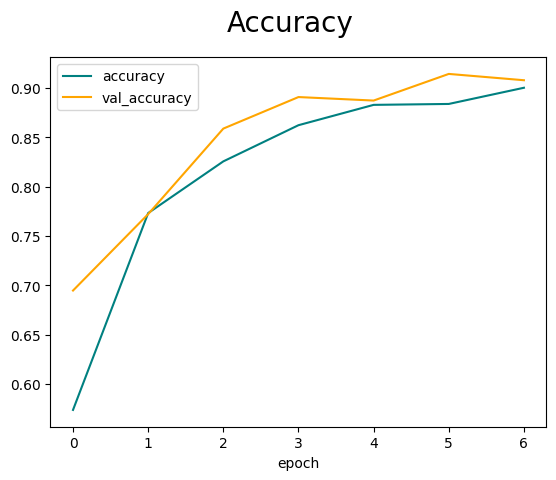

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

#3 Um teste simples:

In [ ]:
from tensorflow.keras.models import load_model

saved_model = load_model('/content/drive/MyDrive/CVCalvos/best_model.h5')

In [ ]:
!ls '/content/drive/MyDrive/CVCalvos/test'

A saída de streaming foi truncada nas últimas 5000 linhas.
 161668.jpg   168335.jpg   175002.jpg
 161669.jpg   168336.jpg   175003.jpg
 161670.jpg   168337.jpg   175004.jpg
 161671.jpg   168338.jpg   175005.jpg
 161672.jpg   168339.jpg   175006.jpg
 161673.jpg   168340.jpg   175007.jpg
 161674.jpg   168341.jpg   175008.jpg
 161675.jpg   168342.jpg   175009.jpg
 161676.jpg   168343.jpg   175010.jpg
 161677.jpg   168344.jpg   175011.jpg
 161678.jpg   168345.jpg   175012.jpg
 161679.jpg   168346.jpg   175013.jpg
 161680.jpg   168347.jpg   175014.jpg
 161681.jpg   168348.jpg   175015.jpg
 161682.jpg   168349.jpg   175016.jpg
 161683.jpg   168350.jpg   175017.jpg
 161684.jpg   168351.jpg   175018.jpg
 161685.jpg   168352.jpg   175019.jpg
 161686.jpg   168353.jpg   175020.jpg
 161687.jpg   168354.jpg   175021.jpg
 161688.jpg   168355.jpg   175022.jpg
 161689.jpg   168356.jpg   175023.jpg
 161690.jpg   168357.jpg   175024.jpg
 161691.jpg   168358.jpg   175025.jpg
 161692.jpg   168359.jpg   17

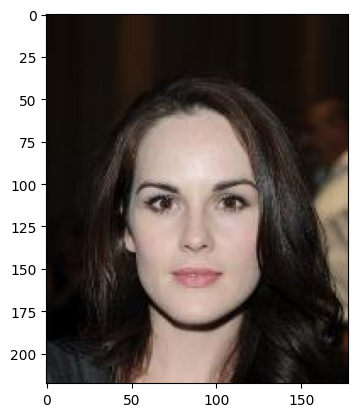

In [ ]:
img = plt.imread('/content/drive/MyDrive/CVCalvos/test/160133.jpg', )
plt.imshow(img)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
class_names=['Bald', 'Notbald']
def previsão_calvice(arquivo):
  img_path = arquivo
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  img_array /= 255.0

  predictions = saved_model.predict(img_array)

  class_index = np.argmax(predictions[0])
  class_label = class_names[class_index]


  print(f'Previsões: {predictions}')
  print(f'Classe prevista: {class_label}')

In [ ]:
previsão_calvice('/content/drive/MyDrive/CVCalvos/test/160133.jpg')

1/1 [==============================] - 7s 7s/step
Previsões: [[0.001803 0.998197]]
Classe prevista: Notbald


In [ ]:
previsão_calvice('/content/drive/MyDrive/CVCalvos/test/160133.jpg')

1/1 [==============================] - 0s 18ms/step
Previsões: [[0.001803 0.998197]]
Classe prevista: Notbald


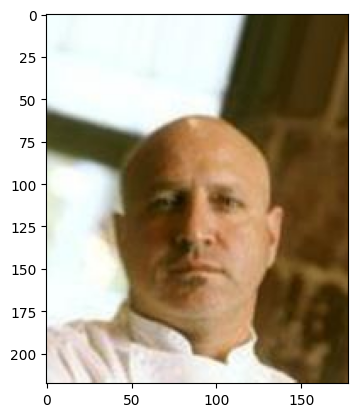

In [ ]:
img = plt.imread('/content/drive/MyDrive/CVCalvos/test/160014.jpg', )
plt.imshow(img)
plt.show()

In [ ]:
previsão_calvice('/content/drive/MyDrive/CVCalvos/test/160014.jpg')

1/1 [==============================] - 0s 23ms/step
Previsões: [[0.6225782 0.3774218]]
Classe prevista: Bald


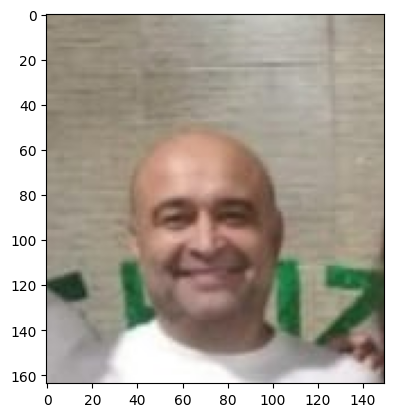

In [ ]:
img = plt.imread('/content/drive/MyDrive/CVCalvos/test/WhatsApp Image 2023-08-29 at 10.27.57.jpeg', )
plt.imshow(img)
plt.show()
#meu pai kkkkkkk

In [ ]:
previsão_calvice('/content/drive/MyDrive/CVCalvos/test/WhatsApp Image 2023-08-29 at 10.27.57.jpeg')

1/1 [==============================] - 0s 21ms/step
Previsões: [[0.97598094 0.02401902]]
Classe prevista: Bald


#4 Agora um teste com modelos já prontos, no caso o ResNet50:

In [ ]:
from tensorflow.keras.applications import ResNet50
base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(2, activation='softmax'))
base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
base_model.compile(optimizer ='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
resnet_history = base_model.fit(train_generator, validation_data = val_generator, steps_per_epoch =100 , epochs = 10)

Epoch 1/10
100/100 [==============================] - 2032s 20s/step - loss: 1.1881 - accuracy: 0.7479 - val_loss: 22293.0977 - val_accuracy: 0.6803
Epoch 2/10
100/100 [==============================] - 385s 4s/step - loss: 0.9943 - accuracy: 0.7077 - val_loss: 0.5989 - val_accuracy: 0.6803
Epoch 3/10
100/100 [==============================] - 123s 1s/step - loss: 0.3321 - accuracy: 0.8664 - val_loss: 0.7276 - val_accuracy: 0.3197
Epoch 4/10
100/100 [==============================] - 77s 767ms/step - loss: 0.3433 - accuracy: 0.8861 - val_loss: 0.7079 - val_accuracy: 0.3197
Epoch 5/10
100/100 [==============================] - 68s 682ms/step - loss: 0.2049 - accuracy: 0.9220 - val_loss: 0.6905 - val_accuracy: 0.6156
Epoch 6/10
100/100 [==============================] - 68s 678ms/step - loss: 0.1569 - accuracy: 0.9449 - val_loss: 0.6888 - val_accuracy: 0.6061
Epoch 7/10
100/100 [==============================] - 67s 674ms/step - loss: 0.1552 - accuracy: 0.9470 - val_loss: 0.7261 - val_ac

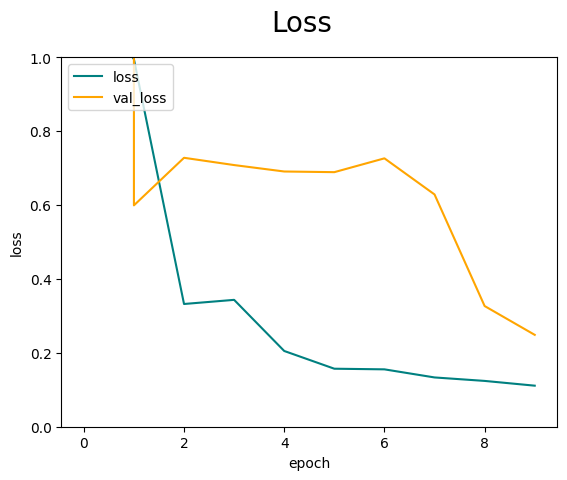

In [ ]:
fig = plt.figure()
plt.plot(resnet_history.history['loss'], color='teal', label='loss')
plt.plot(resnet_history.history['val_loss'], color='orange', label='val_loss')
plt.ylim(0, 1.0)
plt.xlabel('epoch')
plt.ylabel('loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

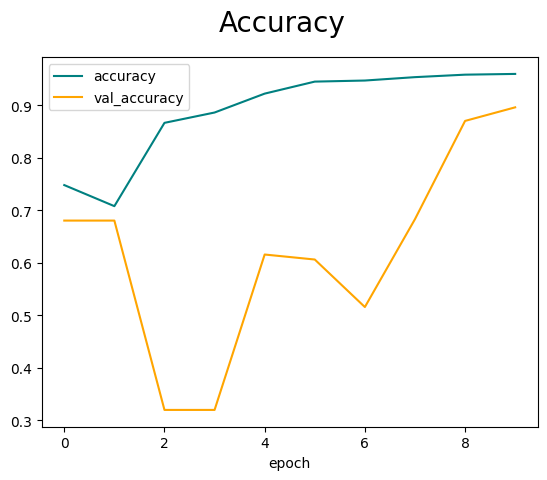

In [ ]:
fig = plt.figure()
plt.plot(resnet_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(resnet_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

Esse modelo apresentou claros problemas iniciais de inconstância nos dados de validação, no meio do treinamento indicava um overfitting, como é possível ver nos gráficos, porém ao final do treinamento os dados com a parte de validação estavam melhorando bastante, provavelmente com mais algumas epochs ele ficaria com bons resultados de acurácia e loss.

In [ ]:
#Ver se consigo aplicar métricas diferentes com o modelo já pronto

#5 Avalição do nosso modelo com métricas diferentes:

In [ ]:
def previsão(arquivo):
  img_path = arquivo
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  predictions = saved_model.predict(img_array)
  class_index = np.argmax(predictions[0])
  return class_index

In [ ]:
from sklearn.metrics import classification_report
import os
validation_data_paths = []
for root, dirs, files in os.walk(val_dir):
    for file in files:
        if file.endswith(".jpg"):
            validation_data_paths.append(os.path.join(root, file))
y_val = [os.path.basename(os.path.dirname(file_path)) for file_path in validation_data_paths]
for f in range(len(y_val)):
  if y_val[f]== 'Bald':
    y_val[f]=0
  else:
    y_val[f]=1
y_pred=[]
subpastas = [subpasta for subpasta in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, subpasta))]
for subpasta in subpastas:
    subpasta_path = os.path.join(val_dir, subpasta)
    for arquivo in os.listdir(subpasta_path):
        if arquivo.endswith(".jpg"):
            img_path = os.path.join(subpasta_path, arquivo)
            prev = previsão(img_path)
            y_pred.append(prev)
report = classification_report(y_val, y_pred)
print(report)

1/1 [==============================] - 0s 157ms/step
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       470
           1       0.96      0.94      0.95      1000

    accuracy                           0.93      1470
   macro avg       0.92      0.93      0.92      1470
weighted avg       0.93      0.93      0.93      1470



In [ ]:
import seaborn as sns

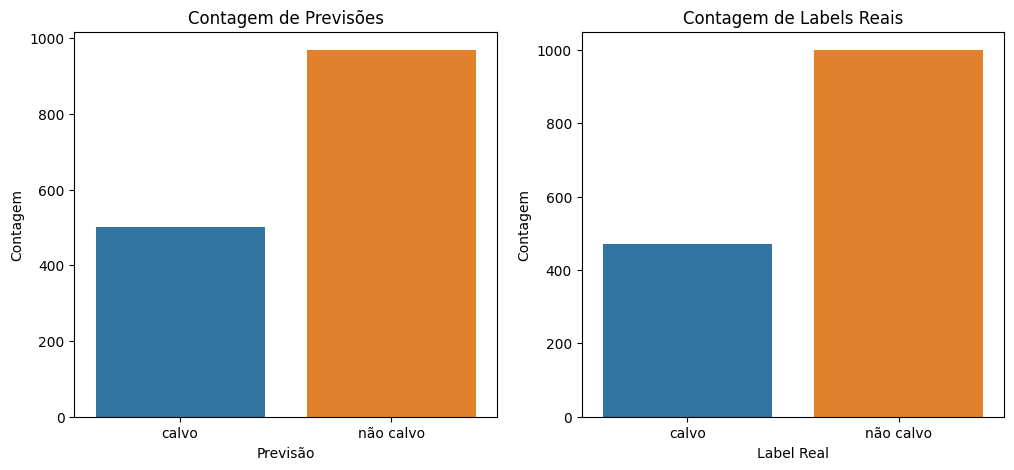

In [ ]:
contagem_real = np.bincount(y_val)
df_contagem_real = pd.DataFrame({'Label Real': ['calvo', 'não calvo'], 'Contagem Real': contagem_real})
contagem_pred = np.bincount(y_pred)
df_contagem_pred = pd.DataFrame({'Previsão': ['calvo', 'não calvo'], 'Contagem Previsão': contagem_pred})

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Previsão', y='Contagem Previsão', data=df_contagem_pred)
plt.xlabel('Previsão')
plt.ylabel('Contagem')
plt.title('Contagem de Previsões')
plt.subplot(1, 2, 2)
sns.barplot(x='Label Real', y='Contagem Real', data=df_contagem_real)
plt.xlabel('Label Real')
plt.ylabel('Contagem')
plt.title('Contagem de Labels Reais')
plt.show()
#Lembrando que 0 = calvo e 1 = não calvo

In [ ]:
from sklearn.metrics import classification_report
y_pred2 = saved_model.predict(val_generator)
y_pred_classes = tf.argmax(y_pred2, axis=1)
report = classification_report(labels_reais, y_pred_classes)
print(report)

23/23 [==============================] - 7s 290ms/step
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       470
           1       0.96      0.94      0.95      1000

    accuracy                           0.93      1470
   macro avg       0.92      0.93      0.92      1470
weighted avg       0.93      0.93      0.93      1470



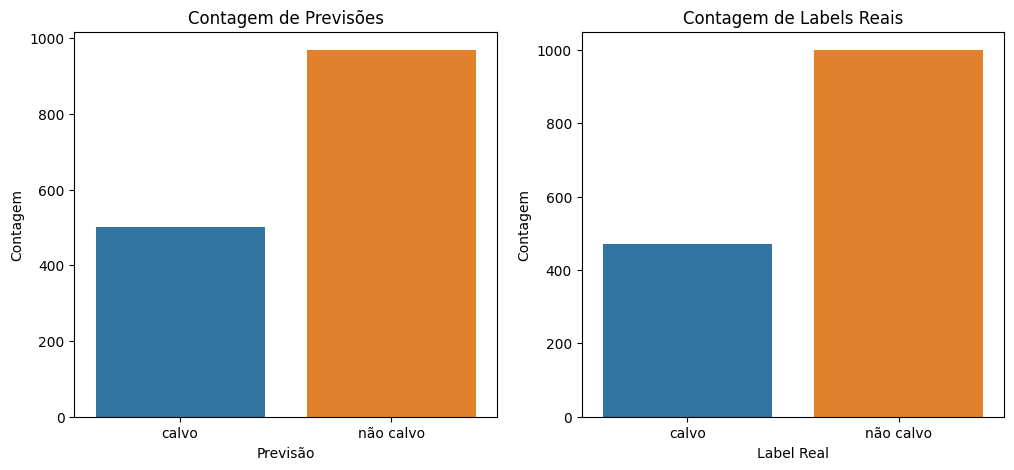

In [ ]:
contagem_pred2 = np.bincount(y_pred_classes)
df_contagem_pred2 = pd.DataFrame({'Previsão': ['calvo', 'não calvo'], 'Contagem Previsão': contagem_pred2})

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Previsão', y='Contagem Previsão', data=df_contagem_pred2)
plt.xlabel('Previsão')
plt.ylabel('Contagem')
plt.title('Contagem de Previsões')
plt.subplot(1, 2, 2)
sns.barplot(x='Label Real', y='Contagem Real', data=df_contagem_real)
plt.xlabel('Label Real')
plt.ylabel('Contagem')
plt.title('Contagem de Labels Reais')
plt.show()

#6 Previsão final:

In [ ]:
import os
import csv

In [ ]:
diretorio_teste='/content/drive/MyDrive/CVCalvos/test'
arquivos_imagem = [f for f in os.listdir(diretorio_teste) if f.endswith('.jpg')]
arquivos_imagem = sorted(arquivos_imagem, key=lambda x: int(x.split('.')[0]))
arquivos_imagem

In [ ]:
num_partes = 100
tamanho_parte = len(arquivos_imagem) // num_partes
partes = []
for i in range(0, len(arquivos_imagem), tamanho_parte):
    parte = arquivos_imagem[i:i + tamanho_parte]
    partes.append(parte)
partes[5]

In [ ]:
from google.colab import files

In [ ]:
for i in range(len(partes)):
  previsoes_numericas = []
  previsões=[]
  for arquivo in partes[i]:
    img_path = os.path.join(diretorio_teste, arquivo)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    predictions = saved_model.predict(img_array)
    class_index = np.argmax(predictions[0])
    class_label = class_names[class_index]
    previsoes_numericas.append(class_index)
    previsões.append(class_label)
  nome_arquivo_csv = f'previsoes_{i}.csv'
  df = pd.DataFrame({'Nome do Arquivo': partes[i], 'Previsão': previsões, 'Previsão_binária': previsoes_numericas})
  df.to_csv(nome_arquivo_csv, index=False)
  files.download(nome_arquivo_csv)
  print(f'Previsões para {len(partes[i])} imagens salvas em "{nome_arquivo_csv}".')

1/1 [==============================] - 0s 137ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_0.csv".
1/1 [==============================] - 0s 101ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_1.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_2.csv".
1/1 [==============================] - 0s 107ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_3.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_4.csv".
1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_5.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_6.csv".
1/1 [==============================] - 0s 111ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_7.csv".
1/1 [==============================] - 0s 108ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_8.csv".
1/1 [==============================] - 0s 103ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_9.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_10.csv".
1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_11.csv".
1/1 [==============================] - 0s 110ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_12.csv".
1/1 [==============================] - 0s 109ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_13.csv".
1/1 [==============================] - 0s 112ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_14.csv".
1/1 [==============================] - 0s 110ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_15.csv".
1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_16.csv".
1/1 [==============================] - 0s 142ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_17.csv".
1/1 [==============================] - 0s 108ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_18.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_19.csv".
1/1 [==============================] - 0s 106ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_20.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_21.csv".
1/1 [==============================] - 0s 103ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_22.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_23.csv".
1/1 [==============================] - 0s 101ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_24.csv".
1/1 [==============================] - 0s 106ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_25.csv".
1/1 [==============================] - 0s 111ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_26.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_27.csv".
1/1 [==============================] - 0s 106ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_28.csv".
1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_29.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_30.csv".
1/1 [==============================] - 0s 107ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_31.csv".
1/1 [==============================] - 0s 107ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_32.csv".
1/1 [==============================] - 0s 109ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_33.csv".
1/1 [==============================] - 0s 145ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_34.csv".
1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_35.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_36.csv".
1/1 [==============================] - 0s 107ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_37.csv".
1/1 [==============================] - 0s 109ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_38.csv".
1/1 [==============================] - 0s 156ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_39.csv".
1/1 [==============================] - 0s 108ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_40.csv".
1/1 [==============================] - 0s 115ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_41.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_42.csv".
1/1 [==============================] - 0s 111ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_43.csv".
1/1 [==============================] - 0s 144ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_44.csv".
1/1 [==============================] - 0s 106ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_45.csv".
1/1 [==============================] - 0s 115ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_46.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_47.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_48.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_49.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_50.csv".
1/1 [==============================] - 0s 148ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_51.csv".
1/1 [==============================] - 0s 110ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_52.csv".
1/1 [==============================] - 0s 110ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_53.csv".
1/1 [==============================] - 0s 106ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_54.csv".
1/1 [==============================] - 0s 148ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_55.csv".
1/1 [==============================] - 0s 108ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_56.csv".
1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_57.csv".
1/1 [==============================] - 0s 139ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_58.csv".
1/1 [==============================] - 0s 103ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_59.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_60.csv".
1/1 [==============================] - 0s 103ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_61.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_62.csv".
1/1 [==============================] - 0s 101ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_63.csv".
1/1 [==============================] - 0s 101ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_64.csv".
1/1 [==============================] - 0s 154ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_65.csv".
1/1 [==============================] - 0s 113ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_66.csv".
1/1 [==============================] - 0s 122ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_67.csv".
1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_68.csv".
1/1 [==============================] - 0s 107ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_69.csv".
1/1 [==============================] - 0s 103ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_70.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_71.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_72.csv".
1/1 [==============================] - 0s 108ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_73.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_74.csv".
1/1 [==============================] - 0s 119ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_75.csv".
1/1 [==============================] - 0s 160ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_76.csv".
1/1 [==============================] - 0s 108ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_77.csv".
1/1 [==============================] - 0s 107ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_78.csv".
1/1 [==============================] - 0s 107ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_79.csv".
1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_80.csv".
1/1 [==============================] - 0s 109ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_81.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_82.csv".
1/1 [==============================] - 0s 101ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_83.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_84.csv".
1/1 [==============================] - 0s 109ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_85.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_86.csv".
1/1 [==============================] - 0s 106ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_87.csv".
1/1 [==============================] - 0s 104ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_88.csv".
1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_89.csv".
1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_90.csv".
1/1 [==============================] - 0s 106ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_91.csv".
1/1 [==============================] - 0s 150ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_92.csv".
1/1 [==============================] - 0s 107ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_93.csv".
1/1 [==============================] - 0s 112ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_94.csv".
1/1 [==============================] - 0s 151ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_95.csv".
1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_96.csv".
1/1 [==============================] - 0s 103ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_97.csv".
1/1 [==============================] - 0s 101ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_98.csv".
1/1 [==============================] - 0s 106ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Previsões para 200 imagens salvas em "previsoes_99.csv".


In [ ]:
partes_concatenadas = []
for i in range(100):
    nome_do_arquivo = f'previsoes_{i}.csv'
    parte_df = pd.read_csv(nome_do_arquivo)
    partes_concatenadas.append(parte_df)
dataset_completo = pd.concat(partes_concatenadas, ignore_index=True)

In [ ]:
dataset_completo

,Nome do Arquivo,Previsão,Previsão_binária
0,160001.jpg,Notbald,1
1,160002.jpg,Notbald,1
2,160003.jpg,Notbald,1
3,160004.jpg,Notbald,1
4,160005.jpg,Notbald,1
...,...,...,...
19995,179996.jpg,Notbald,1
19996,179997.jpg,Notbald,1
19997,179998.jpg,Notbald,1
19998,179999.jpg,Notbald,1


In [ ]:
nome_arquivo_csv = "datasetfinal.csv"
dataset_completo.to_csv(nome_arquivo_csv, index=False)
files.download(nome_arquivo_csv)

#7 Arrumando dataset para alinhar com o da competição:

In [ ]:
df=pd.read_csv("datasetfinal.csv")

In [ ]:
df

,Nome do Arquivo,Previsão,Previsão_binária
0,160001.jpg,Notbald,1
1,160002.jpg,Notbald,1
2,160003.jpg,Notbald,1
3,160004.jpg,Notbald,1
4,160005.jpg,Notbald,1
...,...,...,...
19995,179996.jpg,Notbald,1
19996,179997.jpg,Notbald,1
19997,179998.jpg,Notbald,1
19998,179999.jpg,Notbald,1


In [ ]:
df.rename(columns={'Nome do Arquivo': 'path', 'Previsão_binária': 'Value'}, inplace=True)

In [ ]:
df

,path,Previsão,Value
0,160001.jpg,Notbald,1
1,160002.jpg,Notbald,1
2,160003.jpg,Notbald,1
3,160004.jpg,Notbald,1
4,160005.jpg,Notbald,1
...,...,...,...
19995,179996.jpg,Notbald,1
19996,179997.jpg,Notbald,1
19997,179998.jpg,Notbald,1
19998,179999.jpg,Notbald,1


In [ ]:
df=df.drop('Previsão', axis=1)

In [ ]:
df

,path,Value
0,160001.jpg,1
1,160002.jpg,1
2,160003.jpg,1
3,160004.jpg,1
4,160005.jpg,1
...,...,...
19995,179996.jpg,1
19996,179997.jpg,1
19997,179998.jpg,1
19998,179999.jpg,1


In [ ]:
df['Value']=1-df['Value']

In [ ]:
nome_arquivo_csv = "datasetarrumado2.csv"
df.to_csv(nome_arquivo_csv, index=False)
files.download(nome_arquivo_csv)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df2=pd.read_csv('test.csv')

In [ ]:
print(df2['path'])
print(df['path'])

0           Bald/174823.jpg
1           Bald/167888.jpg
2           Bald/177319.jpg
3           Bald/179334.jpg
4           Bald/163620.jpg
                ...        
19995    NotBald/165937.jpg
19996    NotBald/170484.jpg
19997    NotBald/171942.jpg
19998    NotBald/160697.jpg
19999    NotBald/161589.jpg
Name: path, Length: 20000, dtype: object
0        160001.jpg
1        160002.jpg
2        160003.jpg
3        160004.jpg
4        160005.jpg
            ...    
19995    179996.jpg
19996    179997.jpg
19997    179998.jpg
19998    179999.jpg
19999    180000.jpg
Name: path, Length: 20000, dtype: object


In [ ]:
df['numero'] = df['path'].str.extract(r'(\d+)')
df['numero'] = df['numero'].astype(int)
df2['numero'] = df2['path'].str.extract(r'(\d+)')
df2['numero'] = df2['numero'].astype(int)
df_final = pd.merge(df2, df, on='numero')
df_final

,path_x,bald,numero,path_y,Value
0,Bald/174823.jpg,1,174823,174823.jpg,1
1,Bald/167888.jpg,0,167888,167888.jpg,1
2,Bald/177319.jpg,0,177319,177319.jpg,1
3,Bald/179334.jpg,1,179334,179334.jpg,1
4,Bald/163620.jpg,0,163620,163620.jpg,1
...,...,...,...,...,...
19995,NotBald/165937.jpg,0,165937,165937.jpg,0
19996,NotBald/170484.jpg,0,170484,170484.jpg,0
19997,NotBald/171942.jpg,0,171942,171942.jpg,0
19998,NotBald/160697.jpg,1,160697,160697.jpg,0


In [ ]:
df_final = df_final.drop(['numero','path_x', 'bald'], axis=1)

In [ ]:
df_final

,path_y,Value
0,174823.jpg,1
1,167888.jpg,1
2,177319.jpg,1
3,179334.jpg,1
4,163620.jpg,1
...,...,...
19995,165937.jpg,0
19996,170484.jpg,0
19997,171942.jpg,0
19998,160697.jpg,0


In [ ]:
df_final.rename(columns={'path_y': 'path'}, inplace=True)

In [ ]:
df_final

,path,Value
0,174823.jpg,1
1,167888.jpg,1
2,177319.jpg,1
3,179334.jpg,1
4,163620.jpg,1
...,...,...
19995,165937.jpg,0
19996,170484.jpg,0
19997,171942.jpg,0
19998,160697.jpg,0


In [ ]:
nome_arquivo_csv = "datasetprevisaoarrumado.csv"
df_final.to_csv(nome_arquivo_csv, index=False)
files.download(nome_arquivo_csv)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>